In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
num_data = {
    'netifier': 7773,
    'dat': 500,
    'hsd': 13169,
    'casa': 1080,
    'hoasa': 2854,
}

In [17]:
def average_results(results):
    return pd.concat(results).groupby(level=0).mean()

def plot_results(dataset, result, metric='F1 Micro'):
    data_used = [round(x / num_data[dataset] * 100, 0) for x in result['lc - 1 model']['Data Used']]
    plt.figure(figsize=(15, 10))

    for method in result.keys():
        if method != 'passive - 1 model' and method != 'passive - 2 models':
            plt.plot(data_used, result[method][metric], label=method.upper(), marker='o')
        elif method == 'passive - 1 model':
            plt.plot(data_used, result[method][metric], label=method.upper(), linestyle='--', color='black')
        elif method == 'passive - 2 models':
            plt.plot(data_used, result[method][metric], label=method.upper(), linestyle=':', color='black')

    plt.title(dataset.upper())
    plt.xlabel("Data Used (%)")
    plt.ylabel(metric)
    plt.legend(fontsize='x-large')
    plt.grid(True, axis='x')

    plt.xticks(data_used)
    plt.tight_layout()
    plt.show()

In [18]:
def load_result(dataset, ignored_method=None):
    methods = ['lc', 'mc', 'kmeans', 'coreset', 'random']
    result = {}

    if ignored_method is not None:
        for method in ignored_method:
            methods.remove(method)
    
    for method in methods:
        for i in range (1, 6):
            if i == 1:
                result[method + ' - 1 model'] = [pd.read_csv(f"../{dataset}/metrics/{dataset}-{method}-single-{i}-results.csv")]
            else:
                result[method + ' - 1 model'].append(pd.read_csv(f"../{dataset}/metrics/{dataset}-{method}-single-{i}-results.csv"))

    for method in methods:
        result[method + ' - 1 model'] = average_results(result[method + ' - 1 model'])
    
    passive_result = pd.read_csv(f"../{dataset}/metrics/{dataset}-passive-single-results.csv")
    result['passive - 1 model'] = pd.DataFrame({
        'Accuracy': [np.mean(passive_result['Accuracy']) for i in range(len(result['lc - 1 model']))],
        'F1 Micro': [np.mean(passive_result['F1 Micro']) for i in range(len(result['lc - 1 model']))],
        'F1 Macro': [np.mean(passive_result['F1 Macro']) for i in range(len(result['lc - 1 model']))],
    })

    return result

In [19]:
def load_double_result(dataset, ignored_method=None):
    methods = ['lc', 'mc', 'kmeans', 'coreset', 'random']
    result = {}

    if ignored_method is not None:
        for method in ignored_method:
            methods.remove(method)
    
    for method in methods:
        for i in range (1, 6):
            if i == 1:
                result[method + ' - 2 models'] = [pd.read_csv(f"../{dataset}/metrics/{dataset}-{method}-{i}-results.csv")]
            else:
                result[method + ' - 2 models'].append(pd.read_csv(f"../{dataset}/metrics/{dataset}-{method}-{i}-results.csv"))

    for method in methods:
        result[method + ' - 2 models'] = average_results(result[method + ' - 2 models'])
    
    passive_result = pd.read_csv(f"../{dataset}/metrics/{dataset}-passive-results.csv")
    result['passive - 2 models'] = pd.DataFrame({
        'Accuracy': [np.mean(passive_result['Accuracy']) for i in range(len(result['lc - 2 models']))],
        'F1 Micro': [np.mean(passive_result['F1 Micro']) for i in range(len(result['lc - 2 models']))],
        'F1 Macro': [np.mean(passive_result['F1 Macro']) for i in range(len(result['lc - 2 models']))],
    })

    return result

In [20]:
def highlight_cells(val):
    if val > 0: 
        return 'background-color:lightgreen;color:black'
    elif val < 0:
        return 'background-color:lightcoral;color:black'
    else:
        return 'background-color:lightyellow;color:black'

def compare_results(result, num_data, key, benchmark_type='random', tolerance=0, checkpoint_only=False, ignored_method=None):
    results = {}
    index = []

    if benchmark_type == 'random':
        benchmark = result[benchmark_type][~result[benchmark_type]['Data Used'].astype(int).isin([9216, 9217])]
        benchmark = benchmark[key].values
    else:
        benchmark = result['passive'][key].values[0] - tolerance

    diff = {}

    for method in result.keys():
        if benchmark_type == 'random' and method == 'random':
            continue
        if (ignored_method is not None and method in ignored_method) or method == 'passive':
            continue

        filtered = result[method][~result[method]['Data Used'].astype(int).isin([9216, 9217])]
        if checkpoint_only:
            index = []
            for i in range(len(filtered[key])):
                if round(filtered['Data Used'].iloc[i] / num_data, 2) in [0.50, 0.60, 0.70, 0.80]:
                    index.append(i)

            if benchmark_type == 'passive':
                results['passive'] = [0 for i in range(len(filtered['Data Used']))]
            results[method] = 100 * (filtered[key].iloc[index].values - benchmark) / benchmark
            index = np.round(result['lc']['Data Used'].iloc[index].values / num_data * 100, 1)
        else:
            if not benchmark_type == 'passive':
                # significant_diffs = filtered.copy()
                # significant_diffs = filtered[round(filtered['Data Used'] / num_data <= 0.60, 2)]
                # diff[method] = (100 * (significant_diffs[key].values - benchmark[:significant_diffs.shape[0]]) / benchmark[:significant_diffs.shape[0]]).mean()
                diff[method] = (100 * (filtered[key].values - benchmark[:filtered.shape[0]]) / benchmark[:filtered.shape[0]]).mean()
            
            results[method] = 100 * (filtered[key].values - benchmark)
            index = np.round(filtered['Data Used'].values / num_data * 100, 1)

    if (benchmark_type == 'random'):
        print("Mean Diff:", diff)
            
    df = pd.DataFrame(results, index=index)
    return df

In [21]:
def tabular_plot(df, dataset, title='Δ F1 Micro', ignored_method=None):
    plt.figure(figsize=(12, 8))

    methods = ['LC', 'MC Dropout', 'KMeans', 'Coreset', 'Random']
    methods = [method for method in methods if method not in ignored_method]

    # Create mask for positive and negative values
    mask_neg = df < 0
    mask_pos = df >= 0

    # Initialize the heatmap with labels at the top
    ax = sns.heatmap(df, cmap='Greys', cbar=False, annot=False, linewidths=0.5, 
                    xticklabels=df.columns, yticklabels=df.index)

    ax.xaxis.tick_top()
    ax.set_ylabel('Data Used (%)')
    ax.set_yticklabels([f"{round(val, 0):.0f}%" for val in df.index])
    ax.xaxis.set_label_position('top')
    ax.xaxis.set_ticklabels(methods)

    # Apply red color to negative values and green to positive values
    for i in range(len(df.index)):
        for j in range(len(df.columns)):
            if mask_neg.iloc[i, j]:
                ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='lightcoral', alpha=0.9))
            elif mask_pos.iloc[i, j]:
                ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='lightgreen', alpha=0.9))

    # Format annotations with percentage sign
    annotations = df.map(lambda x: f"{x:.2f}%")

    # Add annotations with black text color
    for i in range(len(df.index)):
        for j in range(len(df.columns)):
            text = plt.text(j + 0.5, i + 0.5, annotations.iloc[i, j],
                        ha="center", va="center", color="black", fontweight='normal')

    plt.title(f'{title} ({dataset})', fontsize=14, pad=40)
    plt.tight_layout()
    plt.show()

# CASA

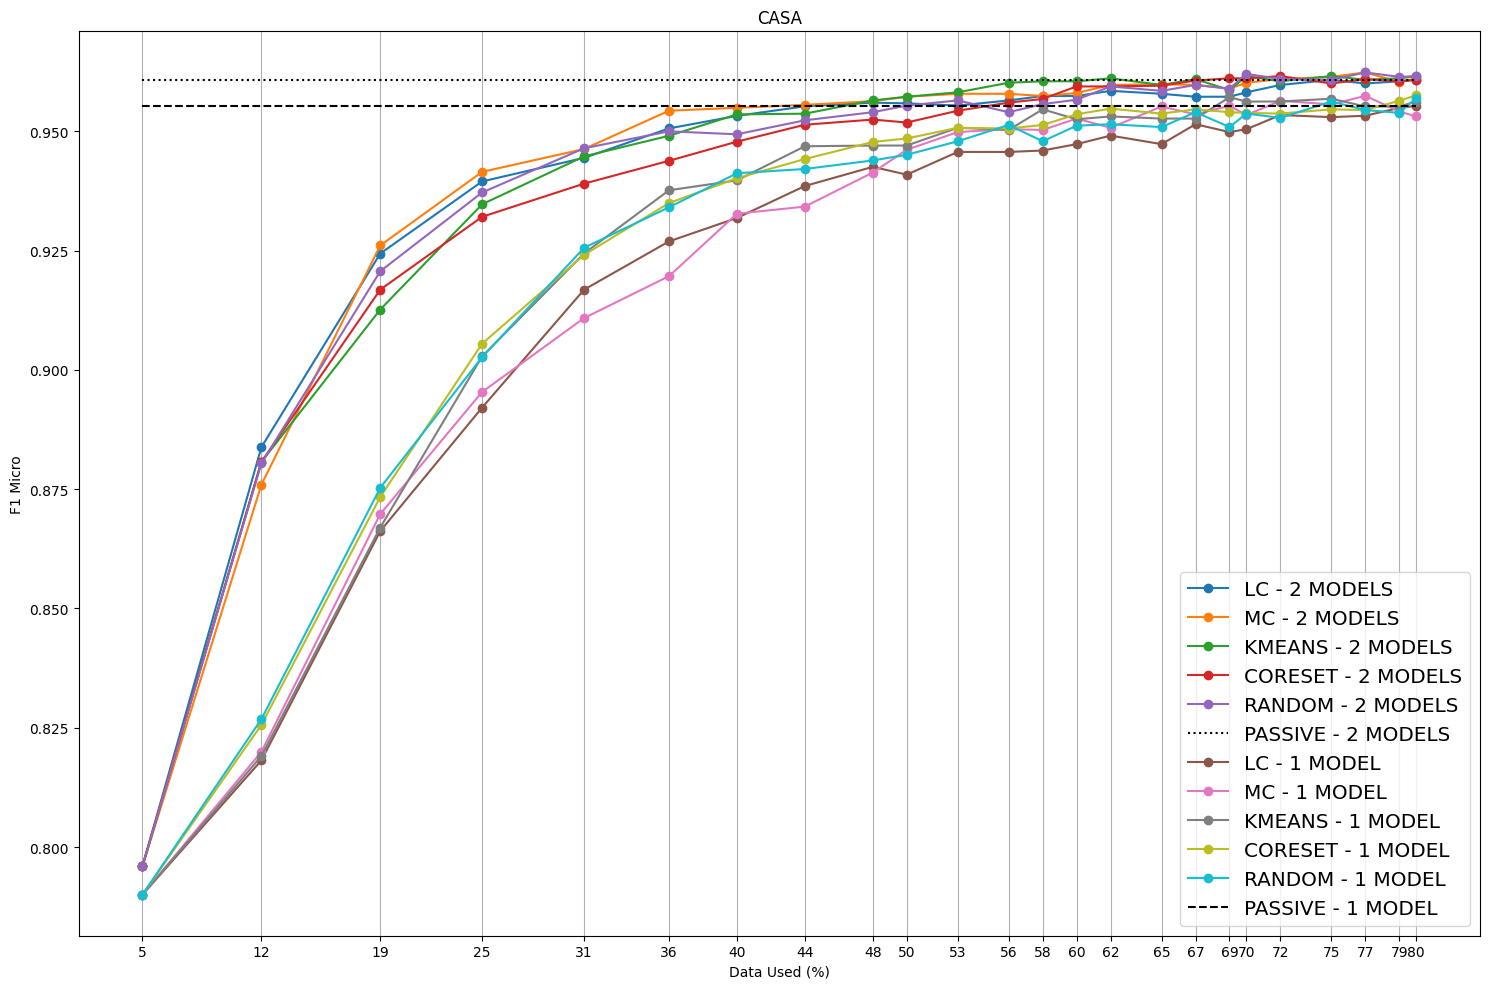

In [22]:
result = load_result('casa')
result_double = load_double_result('casa')

result = result_double | result

plot_results('casa', result)

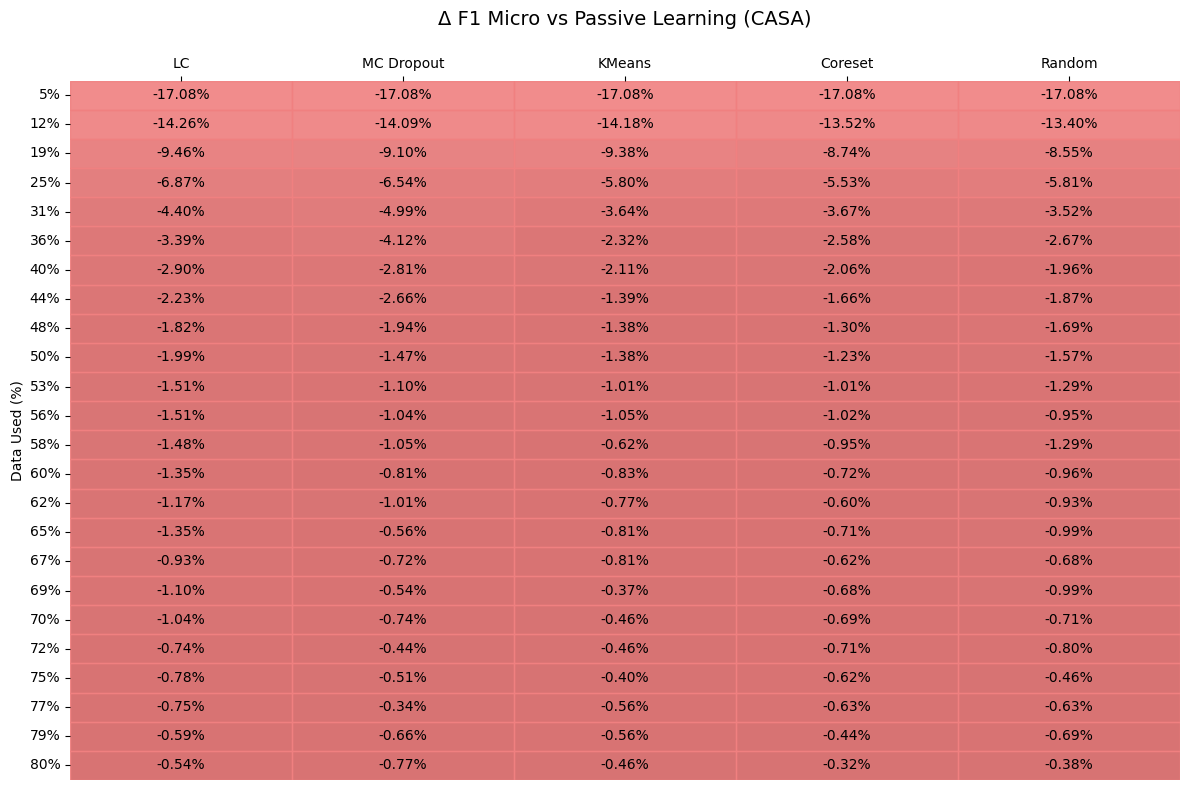

In [8]:
result = load_result("casa")
df = compare_results(result, num_data["casa"], 'F1 Micro', 'passive', 0)
tabular_plot(df, "casa".upper(), 'Δ F1 Micro vs Passive Learning', 'passive')

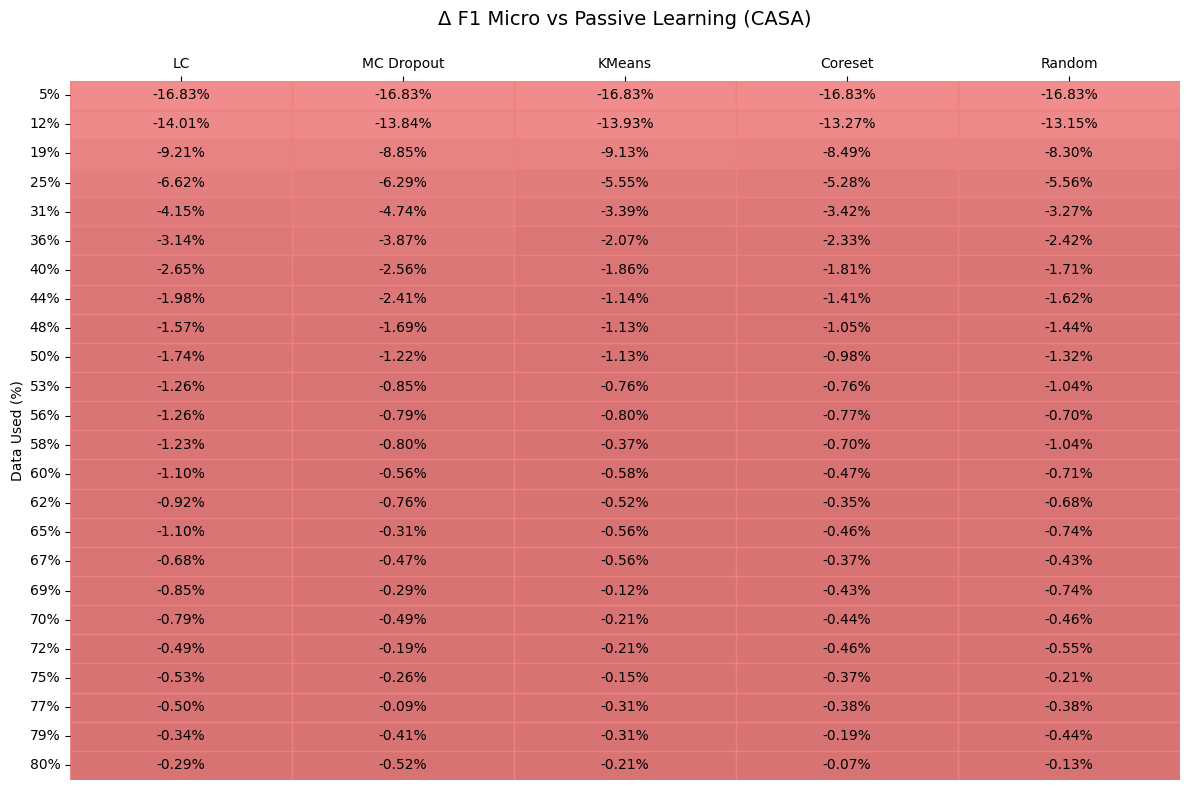

In [9]:
result = load_result("casa")
df = compare_results(result, num_data["casa"], 'F1 Micro', 'passive', 0.0025)
tabular_plot(df, "casa".upper(), 'Δ F1 Micro vs Passive Learning', 'passive')

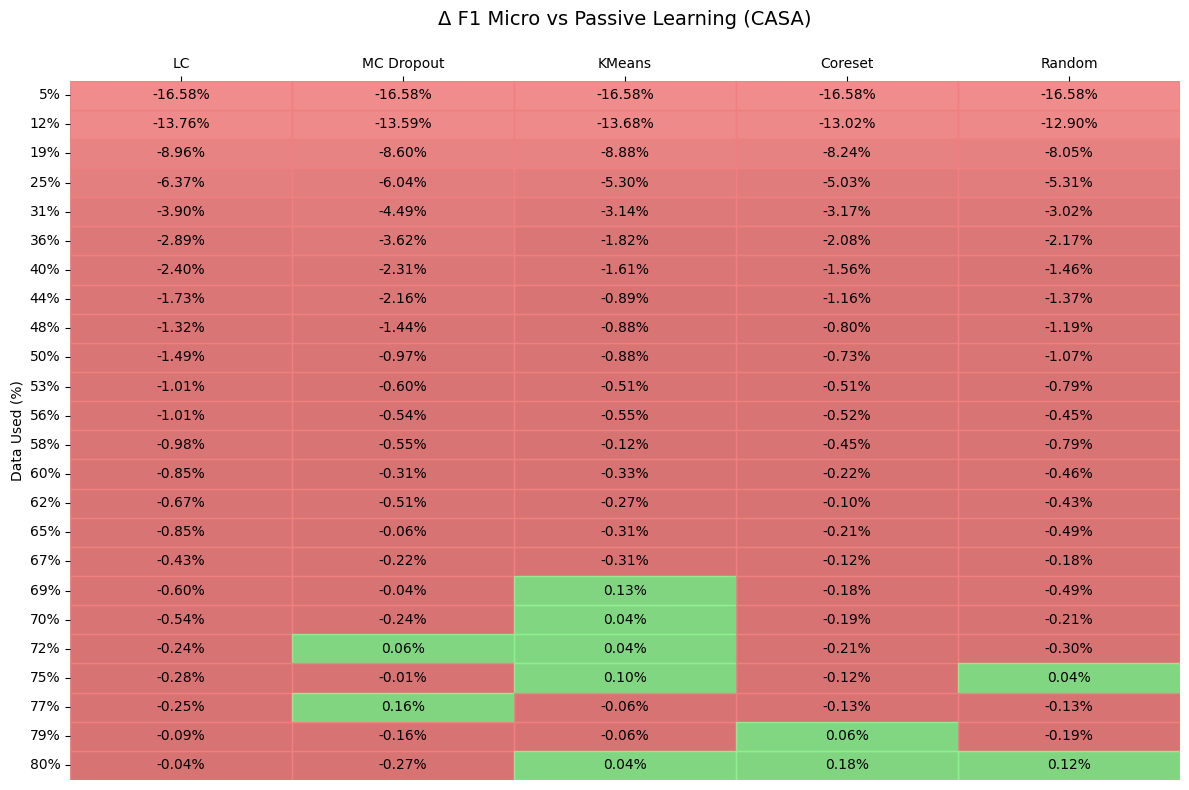

In [10]:
result = load_result("casa")
df = compare_results(result, num_data["casa"], 'F1 Micro', 'passive', 0.005)
tabular_plot(df, "casa".upper(), 'Δ F1 Micro vs Passive Learning', 'passive')

# HOASA

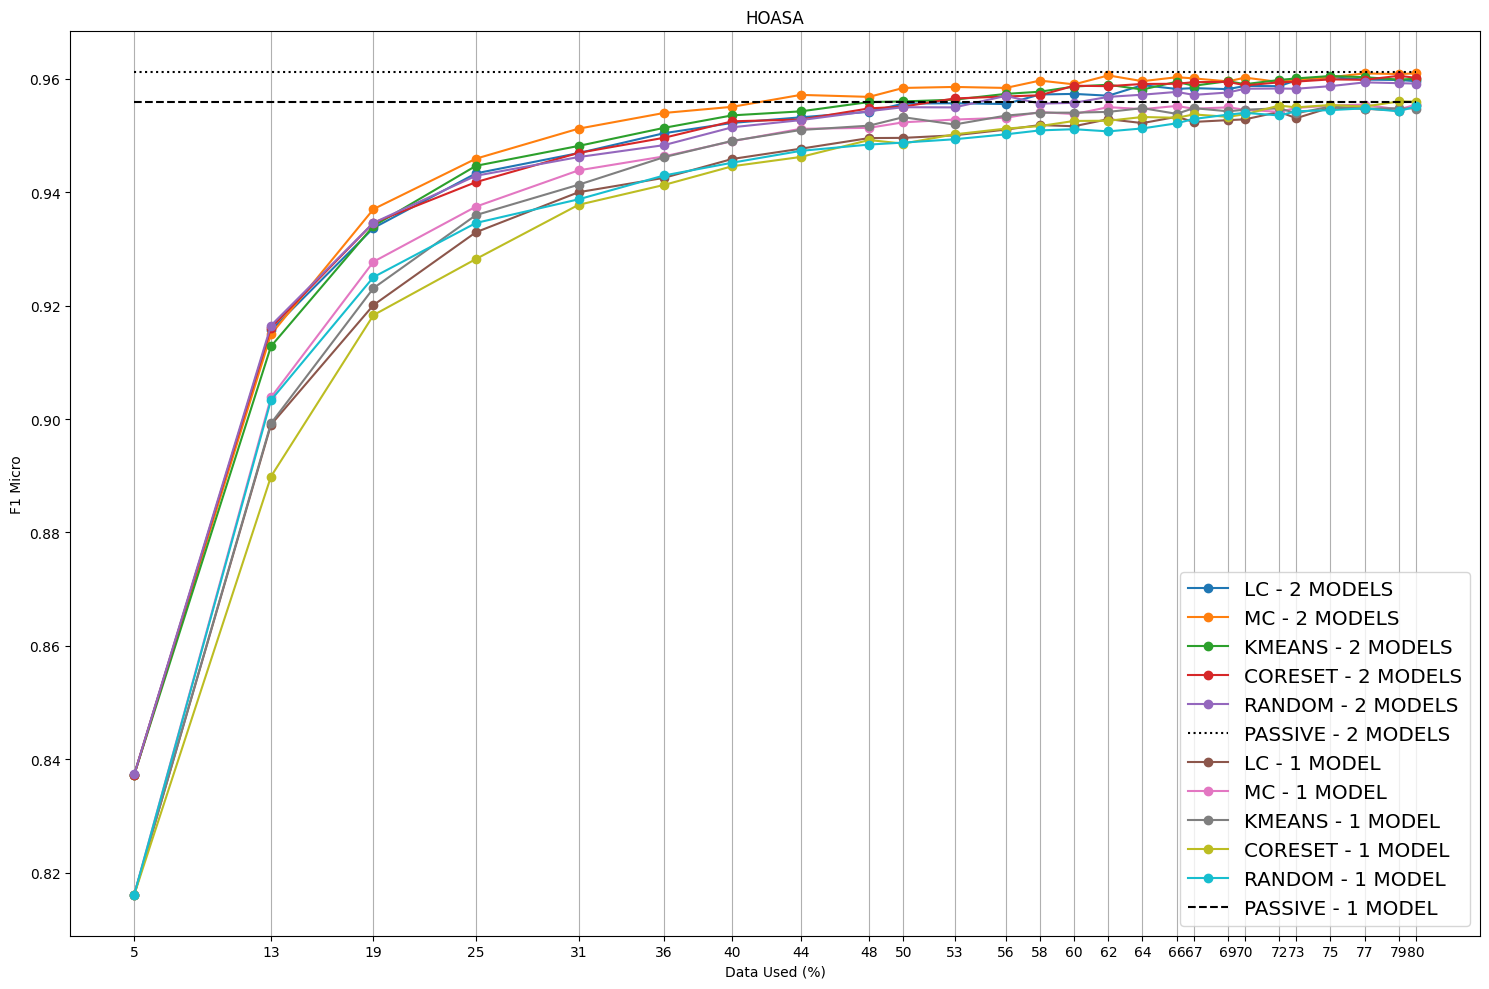

In [23]:
result = load_result('hoasa')
result_double = load_double_result('hoasa')

result = result_double | result

plot_results('hoasa', result)

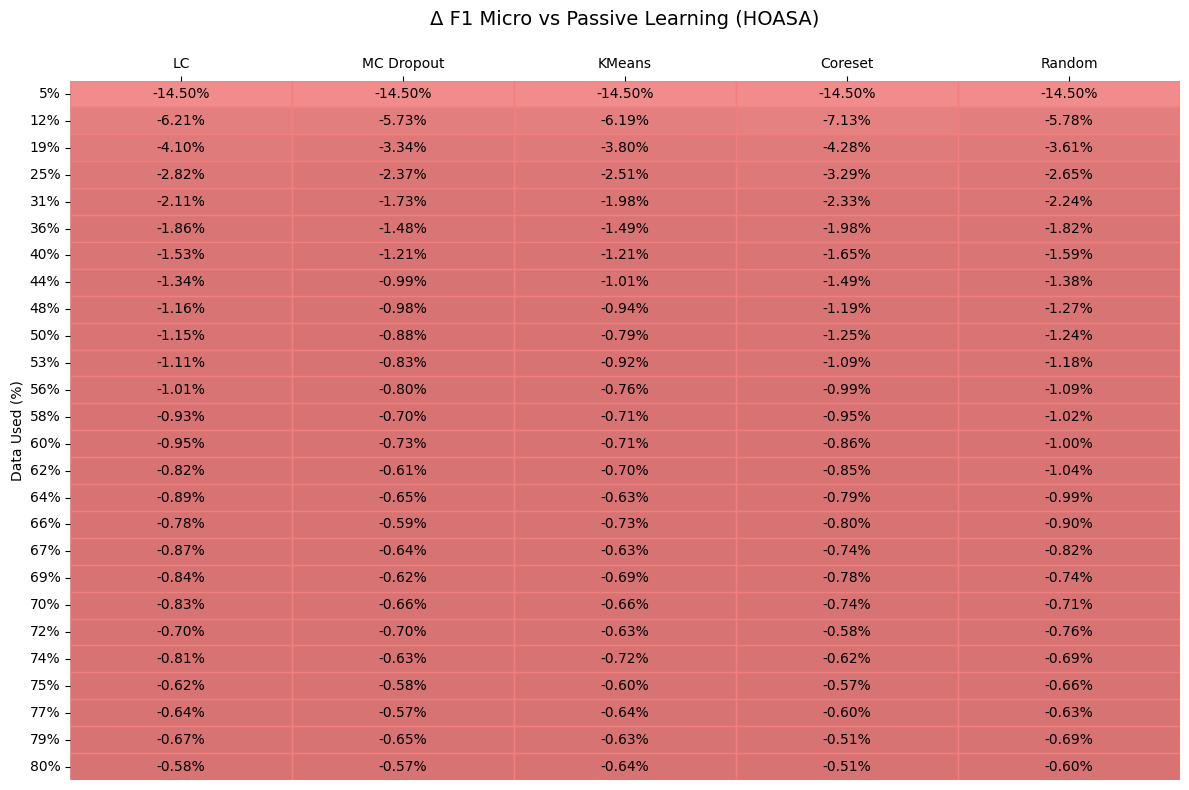

In [12]:
result = load_result("hoasa")
df = compare_results(result, num_data["hoasa"], 'F1 Micro', 'passive', 0)
tabular_plot(df, "hoasa".upper(), 'Δ F1 Micro vs Passive Learning', 'passive')

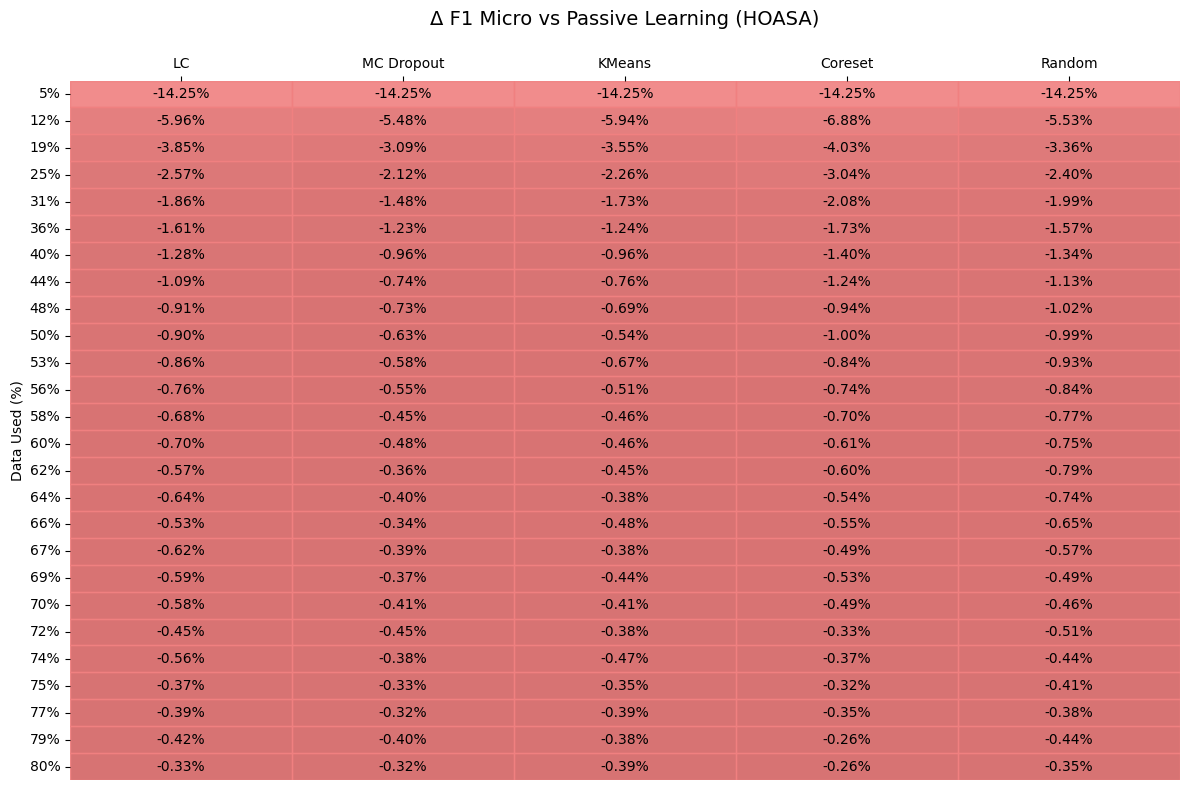

In [13]:
result = load_result("hoasa")
df = compare_results(result, num_data["hoasa"], 'F1 Micro', 'passive', 0.0025)
tabular_plot(df, "hoasa".upper(), 'Δ F1 Micro vs Passive Learning', 'passive')

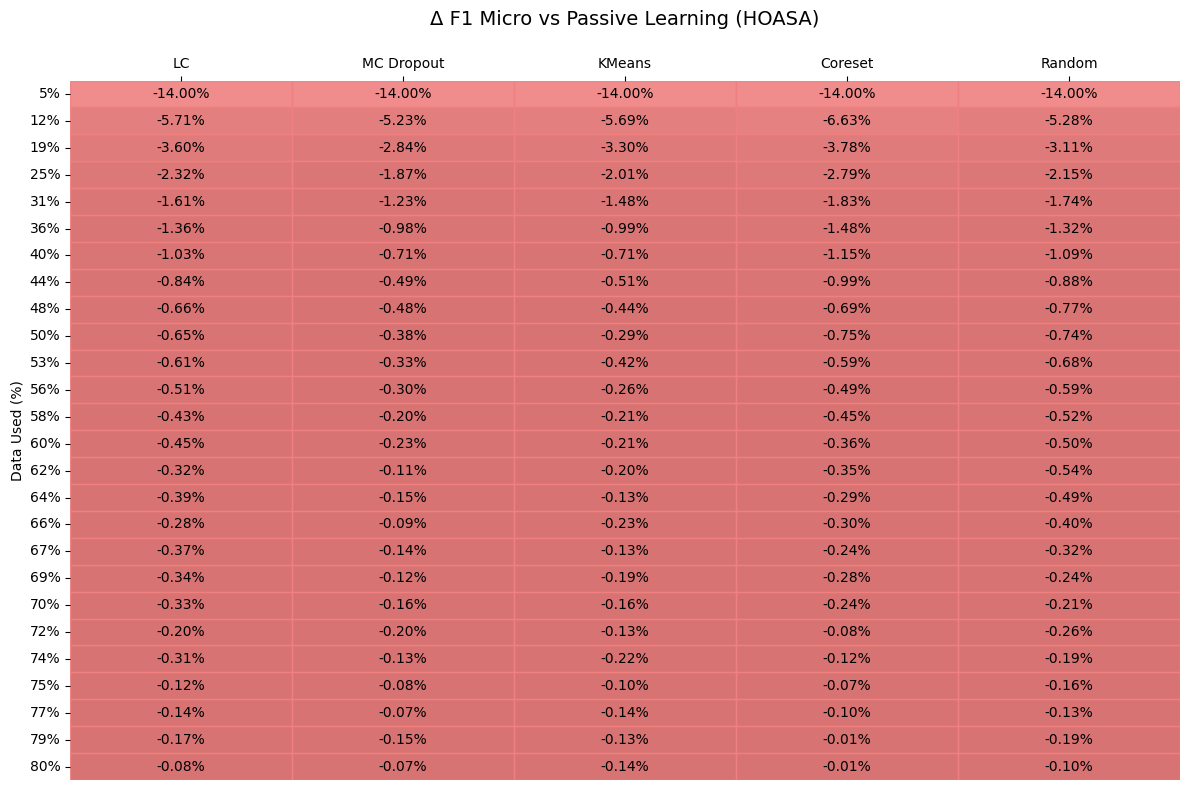

In [14]:
result = load_result("hoasa")
df = compare_results(result, num_data["hoasa"], 'F1 Micro', 'passive', 0.005)
tabular_plot(df, "hoasa".upper(), 'Δ F1 Micro vs Passive Learning', 'passive')